# Create DEM

Take the 2007/08 Rainier DEM Shashank shared. Crop it to the carbon

In [22]:
import geopandas as gpd
import rioxarray
from shapely.geometry import mapping
import matplotlib.pyplot as plt

In [23]:
raster = '/Volumes/MyDrive/hsfm-geomorph/data/reference_dem_highres/rainier_lidar_dsm-adj.tif'

#handdrawn shape
# shapes = "/Volumes/MyDrive/hsfm-geomorph/data/rainier_sub_aois.geojson"
# gdf = gpd.read_file(shapes).to_crs('EPSG:32610')
# gdf = gdf[gdf.name=='carbon']

#official watershed
shapes = '/Users/elischwat/Development/landlab-rainier/data/carbon_watershed.shp'
gdf = gpd.read_file('/Users/elischwat/Development/landlab-rainier/data/carbon_watershed.shp').to_crs('EPSG:32610')

In [24]:
lidar = rioxarray.open_rasterio(raster,masked=True).squeeze()
lidar_clipped = lidar.rio.clip(gdf.geometry.apply(mapping), gdf.crs)
lidar_clipped.rio.to_raster(
    raster.replace('rainier_lidar_dsm-adj.tif', 'rainier_lidar_dsm-adj-carbon-cropped.tif')
)

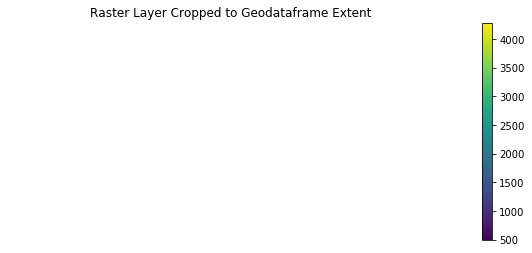

In [25]:
f, ax = plt.subplots(figsize=(10, 4))
lidar_clipped.plot(ax=ax)
ax.set(title="Raster Layer Cropped to Geodataframe Extent")
ax.set_axis_off()
plt.show()

WHY IS THIS NOT PLOTTING

In [29]:
mv /Volumes/MyDrive/hsfm-geomorph/data/reference_dem_highres/rainier_lidar_dsm-adj-carbon-cropped.tif data/carbon_watershed_dem.tif

mv: /Volumes/MyDrive/hsfm-geomorph/data/reference_dem_highres/rainier_lidar_dsm-adj-carbon-cropped.tif: No such file or directory


In [30]:
!gdalinfo data/carbon_watershed_dem.tif | grep NoData

  NoData Value=-3.4028234663852886e+38


In [31]:
!gdalwarp -tr 30 30 data/carbon_watershed_dem.tif data/carbon_watershed_dem_30m.tif

ERROR 1: Output dataset data/carbon_watershed_dem_30m.tif exists,
but some command line options were provided indicating a new dataset
should be created.  Please delete existing dataset and run again.



In [32]:
!gdal_translate -of AAIGrid data/carbon_watershed_dem_30m.tif data/carbon_watershed_dem_30m.asc

Input file size is 466, 525
0...10...20...30...40...50...60...70...80...90...100 - done.


# Landlab it

In [33]:
import numpy as np
import landlab

from landlab.io import read_esri_ascii, write_esri_ascii 

from landlab.components import FlowAccumulator
from landlab.utils import get_watershed_masks_with_area_threshold
from landlab.utils import get_watershed_masks

from landlab.plot.imshow import imshow_grid

## Create the raster model grid of elevation

In [37]:
(rmg, elevations) = read_esri_ascii("data/carbon_watershed_dem_30m.asc", name="topographic__elevation")

Set all no data nodes to "closed" boundaries

In [38]:
rmg.set_nodata_nodes_to_closed(elevations, -3.4028234663852886e+38)

In [39]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (14, 7)

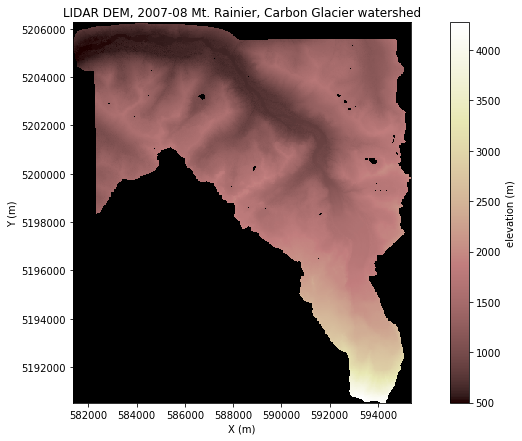

In [40]:
imshow_grid(rmg, 
            'topographic__elevation', 
            plot_name = 'LIDAR DEM, 2007-08 Mt. Rainier, Carbon Glacier watershed', 
            var_name = 'elevation', 
            var_units = 'm', 
            grid_units = ('m','m')
       )

Set watershed boundary condition; i.e. find outlet node

If simple call doesn't work, set the outlet node to be the node with lowest elevation

In [41]:
try:
    outlet_node = rmg.set_watershed_boundary_condition(elevations, return_outlet_id=True, remove_disconnected=True)
except:
    outlet_id = rmg.core_nodes[np.argmin(rmg.at_node['topographic__elevation'][rmg.core_nodes])] # find the lowest point on our DEM?            

    rmg.set_watershed_boundary_condition_outlet_id(outlet_id, elevations)    # set the lowest point as the outlet
    
    print("Outlet ID=", outlet_id)                                        # print outlet id number
    print("Outlet elevation=",rmg.at_node['topographic__elevation'][outlet_id])        # print elevation of outlet node
    print("Min elevation of core nodes=", np.min(rmg.at_node['topographic__elevation'][rmg.core_nodes])) # print minimum elevation of core nodes
    print("Max elevation of core nodes=", np.max(rmg.at_node['topographic__elevation'][rmg.core_nodes])) # print maximum elevation of core nodes

Outlet ID= 221355
Outlet elevation= 497.623779297
Min elevation of core nodes= 498.046142578
Max elevation of core nodes= 4276.15136719


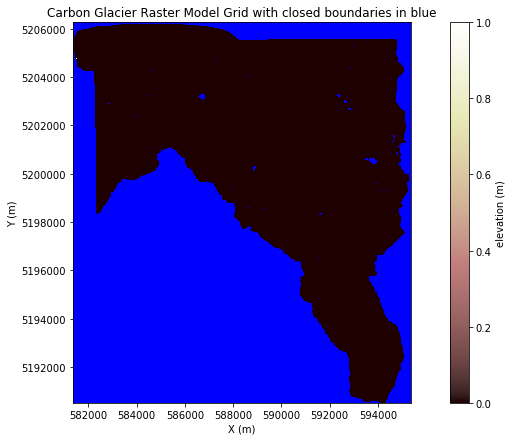

In [42]:
imshow_grid(rmg, 
            rmg.status_at_node, 
            color_for_closed="blue",
            plot_name = 'Carbon Glacier Raster Model Grid with closed boundaries in blue', 
            var_name = 'elevation', 
            var_units = 'm', 
            grid_units = ('m','m')
           )

## Flow routing

### Without depression finder/filler

In [44]:
flow_accum = FlowAccumulator(rmg, 
                           surface='topographic__elevation',
                           flow_director='FlowDirectorD8',
                           depression_finder=None,
                           runoff_rate=None)

In [45]:
da, q = flow_accum.accumulate_flow()

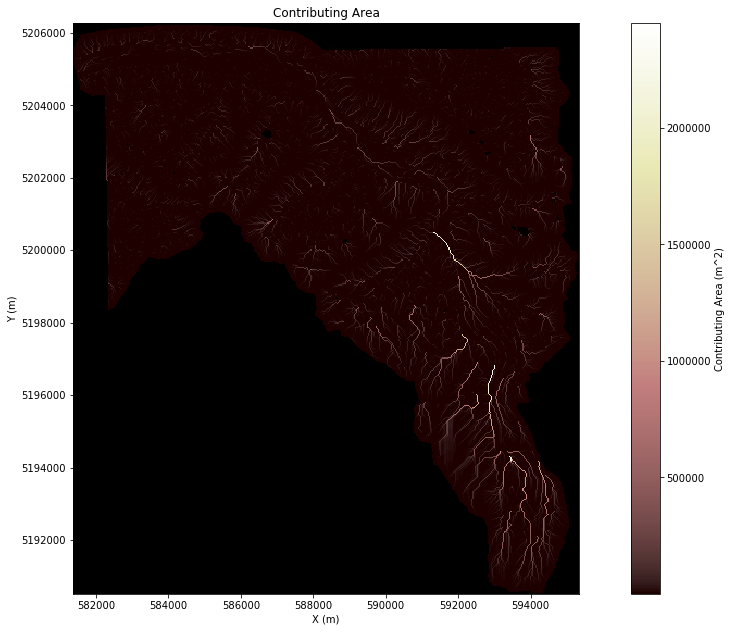

In [46]:
imshow_grid(rmg,'drainage_area', 
            plot_name = 'Contributing Area', 
            var_name = 'Contributing Area', 
            var_units = 'm^2', 
            grid_units = ('m','m')
           )
fig = plt.gcf().set_size_inches(18.5, 10.5)

### With depression finder/filler

In [47]:
from landlab.components import DepressionFinderAndRouter

In [48]:
flow_accum = FlowAccumulator(rmg, 
                           surface='topographic__elevation',
                           flow_director='FlowDirectorD8',
                           depression_finder='DepressionFinderAndRouter',
                           runoff_rate=None)

In [49]:
(da, q) = flow_accum.accumulate_flow()

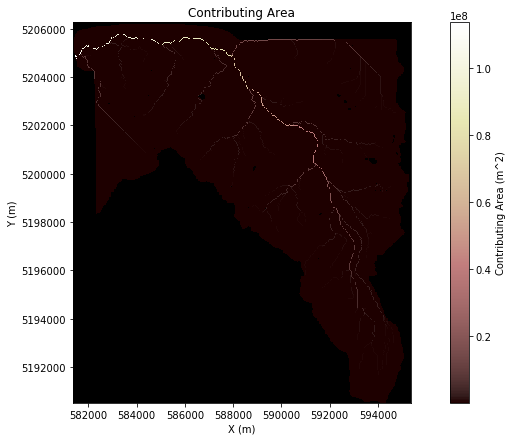

In [52]:
imshow_grid(rmg,'drainage_area', plot_name = 'Contributing Area', 
            var_name = 'Contributing Area', var_units = 'm^2', grid_units = ('m','m'))

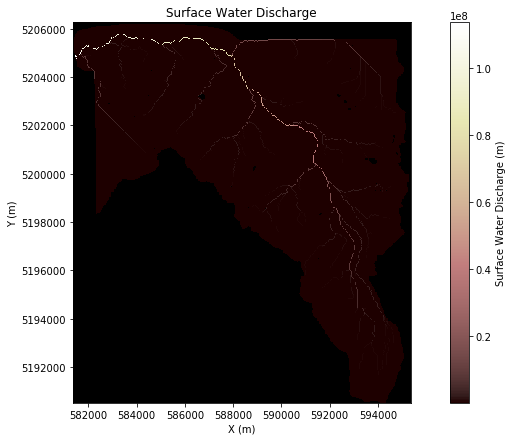

In [53]:
imshow_grid(rmg,'surface_water__discharge', plot_name = 'Surface Water Discharge', 
            var_name = 'Surface Water Discharge', var_units = 'm', grid_units = ('m','m'))

## Simulating Distributed Rainfall

In [54]:
from landlab import imshow_grid_at_node
from landlab.io import read_esri_ascii, write_esri_ascii  # this for exporting the rainfall field as ascii file
from landlab.components import SpatialPrecipitationDistribution
import os

In [55]:
rain = SpatialPrecipitationDistribution(rmg)
np.random.seed(26)
for storm_t, interstorm_t in rain.yield_storms(style='monsoonal'): # storm lengths in hrs???
    rmg.at_node['rainfall__flux'] *= 0.001 #mm/hr
    rmg.at_node['rainfall__flux'] *= 10 # heavier storms...

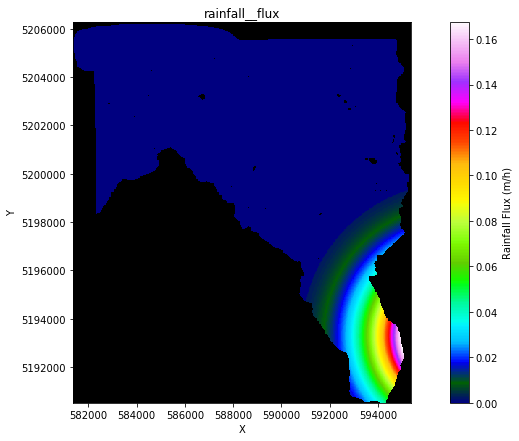

In [56]:
imshow_grid_at_node(rmg, 'rainfall__flux', cmap='gist_ncar', colorbar_label='Rainfall Flux (m/h)', plot_name='Storm 1 Rainfall')

In [57]:
flow_accum = FlowAccumulator(rmg,
                            surface='topographic__elevation',
                            flow_director='FlowDirectorD8',
                            runoff_rate='rainfall__flux', # <-- feed in the rainfall data layer that you just created
                            depression_finder='DepressionFinderAndRouter')
flow_accum.run_one_step()

FlowAccumulator found both the field 'water__unit_flux_in' and a provided float or array for the runoff_rate argument. THE FIELD IS BEING OVERWRITTEN WITH THE SUPPLIED RUNOFF_RATE!


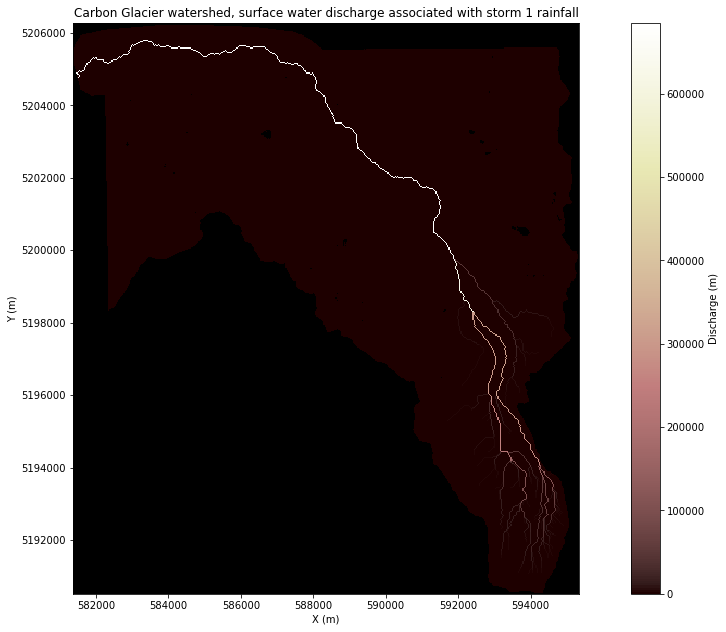

In [58]:
imshow_grid(rmg, 
            'surface_water__discharge',
            plot_name = 'Carbon Glacier watershed, surface water discharge associated with storm 1 rainfall', 
            var_name = 'Discharge', 
            var_units = 'm', 
            grid_units = ('m','m')
           )
fig = plt.gcf().set_size_inches(18.5, 10.5)

In [59]:
print('max surface water discharge (m^3/hr)=', np.max(rmg.at_node['surface_water__discharge'][rmg.nodes]))

max surface water discharge (m^3/hr)= 684980.6875


In [60]:
rain = SpatialPrecipitationDistribution(rmg)
np.random.seed(13)
for storm_t, interstorm_t in rain.yield_storms(style='monsoonal'): # storm lengths in hrs???
    rmg.at_node['rainfall__flux'] *= 0.001 #mm/hr
    rmg.at_node['rainfall__flux'] *= 10 # heavier storms...


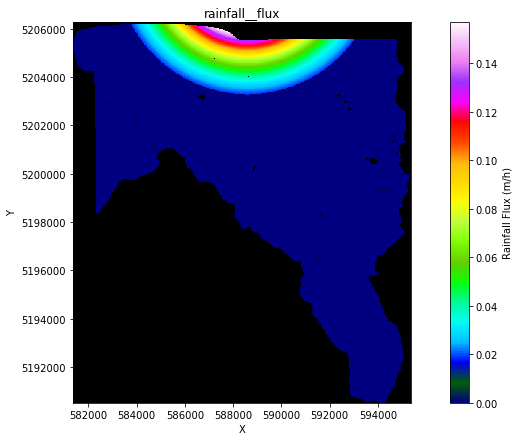

In [61]:
imshow_grid_at_node(rmg, 'rainfall__flux', cmap='gist_ncar', colorbar_label='Rainfall Flux (m/h)', plot_name='Storm 1 Rainfall')

In [62]:
flow_accum = FlowAccumulator(rmg,
                            surface='topographic__elevation',
                            flow_director='FlowDirectorD8',
                            runoff_rate='rainfall__flux', # <-- feed in the rainfall data layer that you just created
                            depression_finder='DepressionFinderAndRouter')
flow_accum.run_one_step()

FlowAccumulator found both the field 'water__unit_flux_in' and a provided float or array for the runoff_rate argument. THE FIELD IS BEING OVERWRITTEN WITH THE SUPPLIED RUNOFF_RATE!


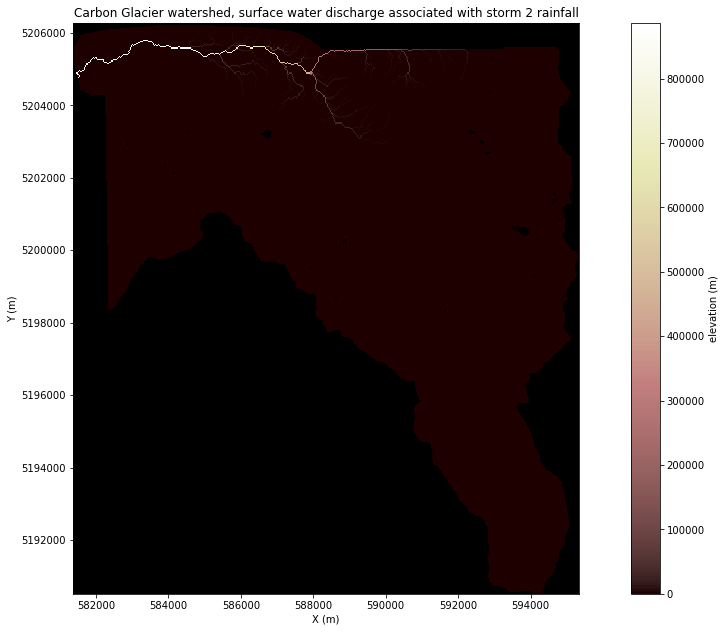

In [63]:
imshow_grid(rmg, 
            'surface_water__discharge',
            plot_name = 'Carbon Glacier watershed, surface water discharge associated with storm 2 rainfall', 
            var_name = 'elevation', 
            var_units = 'm', 
            grid_units = ('m','m')
           )
fig = plt.gcf().set_size_inches(18.5, 10.5)

## TOPMODEL Wetness Index

In [64]:
# remember the elevations variable from when we created the raster model grid with the DEM
slopes = rmg.calc_slope_at_node(elevations)
_ = rmg.add_field('node', 'Slope', slopes, clobber=True)

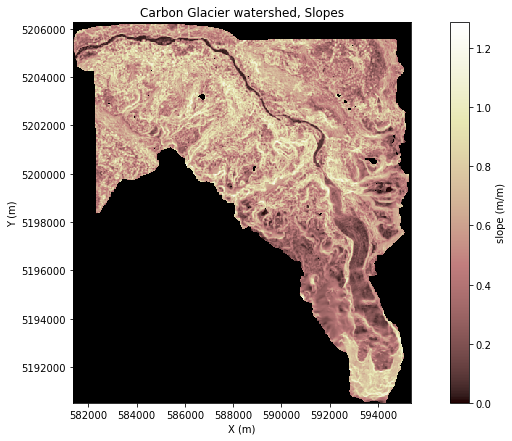

In [65]:
imshow_grid(rmg, 
            'Slope',
            plot_name = 'Carbon Glacier watershed, Slopes', 
            var_name = 'slope', 
            var_units = 'm/m', 
            grid_units = ('m','m')
           )
plt.gcf().set_size_inches(14, 7)

remove zero slopes

In [66]:
rmg.at_node['Slope'][np.where(slopes==0)] = 0.00001       # small slope at cells with no slope
rmg.at_node['drainage_area'][np.where(da==0)] = 10   # small contributing area for the first cell of the grid on hilltop. 

In [67]:
TWI=np.log((rmg.at_node['drainage_area']/10)/rmg.at_node['Slope'])

## set clobber true because you may need to re-write this field in your experiment ?????
rmg.add_field('node','TWI', TWI, clobber=True) 

array([ 11.51292546,  11.51292546,  11.51292546, ...,  11.51292546,
        11.51292546,  11.51292546])

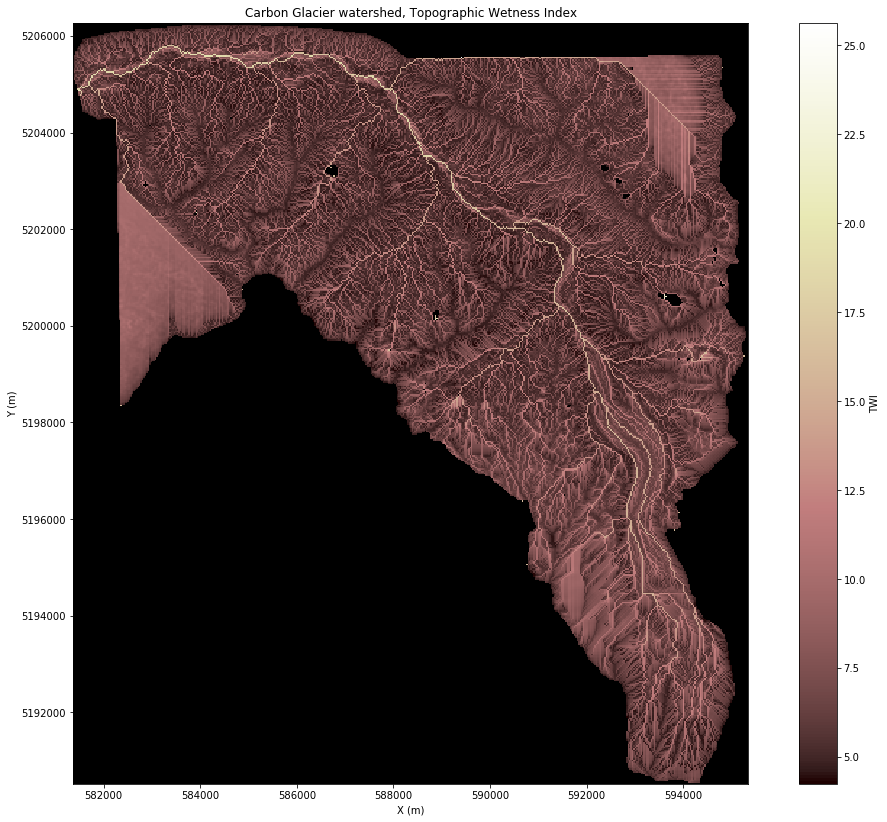

In [68]:
imshow_grid(rmg,
            'TWI',
            plot_name = 'Carbon Glacier watershed, Topographic Wetness Index', 
            var_name = 'TWI', 
            grid_units = ('m','m')
           )
plt.gcf().set_size_inches(18, 14)

In [69]:
SAT=np.zeros(rmg.number_of_nodes)
_=rmg.add_field('node','saturation',SAT,clobber=True) 
T=10;
r=0.020;
rmg.at_node['saturation'][np.where(TWI>=np.log(T/r))] = 1 
rmg.at_node['saturation']

array([ 1.,  1.,  1., ...,  1.,  1.,  1.])

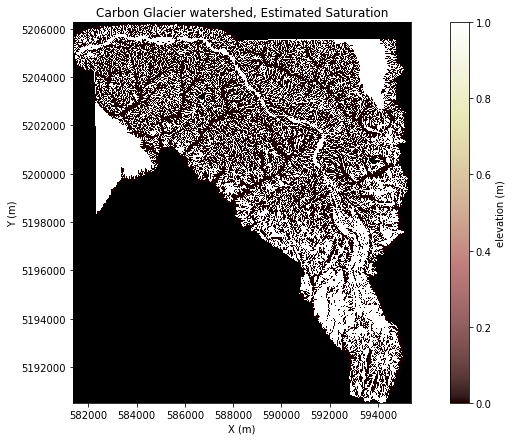

In [70]:
imshow_grid(rmg,
            'saturation',
            plot_name = 'Carbon Glacier watershed, Estimated Saturation', 
            var_name = 'elevation', 
            var_units = 'm', 
            grid_units = ('m','m')
           )
plt.gcf().set_size_inches(14, 7)

In [71]:
Fsat=np.sum(SAT)/(rmg.number_of_nodes)
print('Saturation fraction=',Fsat)

Saturation fraction= 0.737612916411
